# 1. Create Data

In [1]:
from sklearn.datasets import make_circles

X, y = make_circles(
    n_samples= 1000,
    noise = 0.03,
    random_state = 42,
)

In [2]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[ 0.7542,  0.2315],
         [-0.7562,  0.1533],
         [-0.8154,  0.1733],
         [-0.3937,  0.6929],
         [ 0.4422, -0.8967]]),
 tensor([1., 1., 1., 1., 0.]))

In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

len(X_train), len(y_train), len(X_test), len(y_test)

(800, 800, 200, 200)

# 2. Build Model

In [4]:
import torch
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'

class CircleModelV0(nn.Module):
    def __init__(self,):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=5)
        self.layer2 = nn.Linear(in_features=5, out_features=1)

    def forward(self, x):
        return self.layer2(self.layer1(x))

model_0 = CircleModelV0().to(device)
model_0

CircleModelV0(
  (layer1): Linear(in_features=2, out_features=5, bias=True)
  (layer2): Linear(in_features=5, out_features=1, bias=True)
)

In [5]:
## Defining Model sequentially
model_0 = nn.Sequential(
    nn.Linear(in_features=2, out_features=5),
    nn.Linear(in_features=5, out_features=1)
).to(device)

model_0

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [6]:
untrained_preds = model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_preds)}, Shape: {untrained_preds.shape}")
print(f"Length of test samples: {len(y_test)}, Shape: {y_test.shape}")
print(f"\nFirst 10 predictions:\n{untrained_preds[:10]}")
print(f"\nFirst 10 test labels:\n{y_test[:10]}")

Length of predictions: 200, Shape: torch.Size([200, 1])
Length of test samples: 200, Shape: torch.Size([200])

First 10 predictions:
tensor([[-0.7617],
        [-0.6335],
        [-1.1067],
        [-0.6639],
        [-1.1210],
        [-1.0427],
        [-0.6704],
        [-0.7663],
        [-1.1056],
        [-0.6251]], grad_fn=<SliceBackward0>)

First 10 test labels:
tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.])


### 2.1 Setup Loss and optimizer

In [7]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model_0.parameters(),lr = 0.1)

In [8]:
### Accuracy Metric
def accuracy_fn(y_pred, y_true):
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct/len(y_pred))*100
    
    return acc

# 3. Train a Model

In [9]:
torch.manual_seed(42)

EPOCHS = 100

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):

    ### Training mode ###
    model_0.train()

    y_logits = model_0(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    # FOR BCEWithLogitsLoss
    loss = loss_fn(y_logits, y_train)
    # For BCELoss
    # loss = loss_fn(torch.sigmoid(y_logits), y_train)

    # accuracy
    acc = accuracy_fn(y_pred=y_preds, y_true=y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    #### Evaluation ####
    model_0.eval()

    with torch.inference_mode():
        y_test_logits = model_0(X_test).squeeze()
        y_test_preds = torch.round(torch.sigmoid(y_test_logits))

        test_loss = loss_fn(y_test_preds, y_test)
        test_acc = accuracy_fn(y_test_preds, y_test)

    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")
    

Epoch: 0 | Loss: 0.80200, Accuracy: 50.00% | Test loss: 0.69315, Test acc: 50.00%
Epoch: 10 | Loss: 0.73115, Accuracy: 50.00% | Test loss: 0.69315, Test acc: 50.00%
Epoch: 20 | Loss: 0.70840, Accuracy: 49.25% | Test loss: 0.71485, Test acc: 46.50%
Epoch: 30 | Loss: 0.70029, Accuracy: 45.62% | Test loss: 0.74728, Test acc: 46.50%
Epoch: 40 | Loss: 0.69706, Accuracy: 48.50% | Test loss: 0.76119, Test acc: 46.00%
Epoch: 50 | Loss: 0.69560, Accuracy: 49.62% | Test loss: 0.76220, Test acc: 47.00%
Epoch: 60 | Loss: 0.69483, Accuracy: 49.75% | Test loss: 0.76650, Test acc: 46.50%
Epoch: 70 | Loss: 0.69435, Accuracy: 50.12% | Test loss: 0.76890, Test acc: 46.50%
Epoch: 80 | Loss: 0.69403, Accuracy: 50.38% | Test loss: 0.77320, Test acc: 46.00%
Epoch: 90 | Loss: 0.69380, Accuracy: 50.75% | Test loss: 0.77130, Test acc: 46.50%


# 4. Make predictions and improve the model

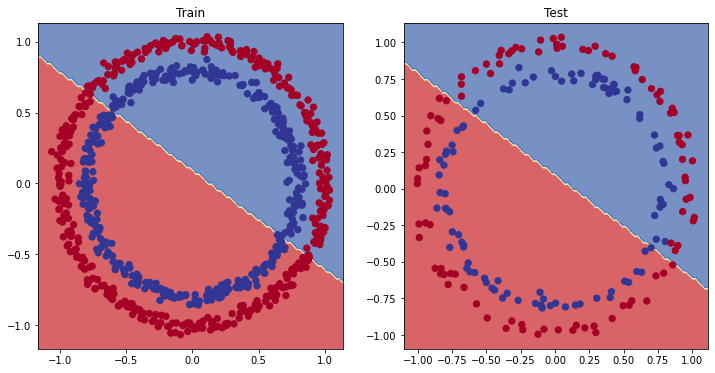

In [10]:
from helper_functions import plot_predictions, plot_decision_boundary
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)

# 5.Improve the model
The model isnt fitting because we used Linear layers

In [11]:
class CircleModelV1(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1= nn.Linear(in_features=2, out_features=10)
        self.layer2= nn.Linear(in_features=10, out_features=10)
        self.layer3= nn.Linear(in_features=10, out_features=1)

    def forward(self, x):
        return self.layer3(self.layer2(self.layer1(x)))

model_1 = CircleModelV1()
model_1

CircleModelV1(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
)

In [13]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_1.parameters(),lr=0.1)

In [14]:
torch.manual_seed(42)

EPOCHS = 1000

X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(EPOCHS):

    # Training model
    model_1.train()

    y_logits = model_1(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    # loss = loss_fn(torch.sigmoid(y_logits), y_train)
    acc = accuracy_fn(y_preds, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### testing
    model_1.eval()

    with torch.inference_mode():
        test_logits = model_1(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)

        test_acc = accuracy_fn(test_preds, y_test)
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.69396, Accuracy: 50.88% | Test loss: 0.69261, Test acc: 51.00%
Epoch: 100 | Loss: 0.69305, Accuracy: 50.38% | Test loss: 0.69379, Test acc: 48.00%
Epoch: 200 | Loss: 0.69299, Accuracy: 51.12% | Test loss: 0.69437, Test acc: 46.00%
Epoch: 300 | Loss: 0.69298, Accuracy: 51.62% | Test loss: 0.69458, Test acc: 45.00%
Epoch: 400 | Loss: 0.69298, Accuracy: 51.12% | Test loss: 0.69465, Test acc: 46.00%
Epoch: 500 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69467, Test acc: 46.00%
Epoch: 600 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 700 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 800 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%
Epoch: 900 | Loss: 0.69298, Accuracy: 51.00% | Test loss: 0.69468, Test acc: 46.00%


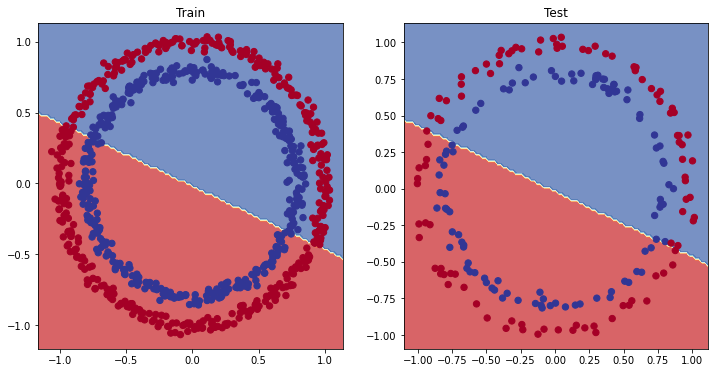

In [15]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_1, X_test, y_test)

# 6. Adding Non-Linearity


In [22]:
class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(in_features=2, out_features=10)
        self.layer2 = nn.Linear(in_features=10, out_features=10)
        self.layer3 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()
        # self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # return self.sigmoid(self.layer3(self.relu(self.layer2(self.relu(self.layer1)))))
        return (self.layer3(self.relu(self.layer2(self.relu(self.layer1(x))))))

model_2 = CircleModelV2()
model_2

CircleModelV2(
  (layer1): Linear(in_features=2, out_features=10, bias=True)
  (layer2): Linear(in_features=10, out_features=10, bias=True)
  (layer3): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)

In [30]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(model_2.parameters(),lr = 0.001)

In [31]:
torch.manual_seed(42)

epochs = 1000

# pass data to appropriate device

for epoch in range(epochs):

    model_2.train()

    y_logits = model_2(X_train).squeeze()
    y_preds = torch.round(torch.sigmoid(y_logits))

    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_preds, y_train)

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

    ### Testing
    model_2.eval()
    with torch.inference_mode():
        test_logits = model_2(X_test).squeeze()
        test_preds = torch.round(torch.sigmoid(test_logits))

        test_loss = loss_fn(test_logits, y_test)
        test_acc = accuracy_fn(test_preds, y_test)

    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

    

Epoch: 0 | Loss: 0.48143, Accuracy: 93.50% | Test Loss: 0.50009, Test Accuracy: 90.00%
Epoch: 100 | Loss: 0.48041, Accuracy: 93.50% | Test Loss: 0.49926, Test Accuracy: 90.50%
Epoch: 200 | Loss: 0.47940, Accuracy: 93.62% | Test Loss: 0.49843, Test Accuracy: 90.50%
Epoch: 300 | Loss: 0.47837, Accuracy: 93.62% | Test Loss: 0.49760, Test Accuracy: 90.50%
Epoch: 400 | Loss: 0.47735, Accuracy: 93.88% | Test Loss: 0.49676, Test Accuracy: 90.00%
Epoch: 500 | Loss: 0.47633, Accuracy: 93.88% | Test Loss: 0.49591, Test Accuracy: 90.00%
Epoch: 600 | Loss: 0.47530, Accuracy: 94.12% | Test Loss: 0.49506, Test Accuracy: 90.00%
Epoch: 700 | Loss: 0.47428, Accuracy: 94.25% | Test Loss: 0.49419, Test Accuracy: 90.00%
Epoch: 800 | Loss: 0.47325, Accuracy: 94.25% | Test Loss: 0.49333, Test Accuracy: 90.00%
Epoch: 900 | Loss: 0.47222, Accuracy: 94.25% | Test Loss: 0.49247, Test Accuracy: 90.00%


In [32]:
model_2.eval()
with torch.inference_mode():
    y_preds = torch.round(torch.sigmoid(model_2(X_test).squeeze()))

y_preds[:10], y[:10]

(tensor([1., 1., 1., 0., 1., 1., 0., 0., 1., 0.]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

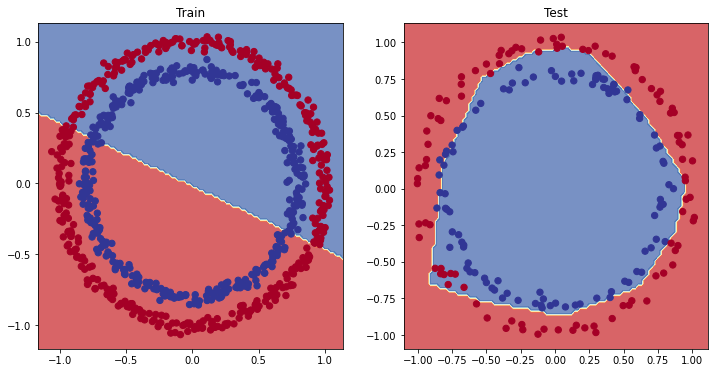

In [33]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_1, X_train, y_train) # model_1 = no non-linearity
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_2, X_test, y_test) # model_3 = has non-linearity

# 7. Replicating Non Linear Functions